# 梯度下降优化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils 
import testCase 

plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

E:\pythonfile\coursera\2.Improving Deep Neural Networks\第二周 优化算法\opt_utils.py:76: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
E:\pythonfile\coursera\2.Improving Deep Neural Networks\第二周 优化算法\opt_utils.py:77: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


## 普通梯度下降
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2}$$

In [2]:
def update_parameters_with_gd(parameters,grads,learning_rate):
    L = len(parameters) // 2 #神经网络的层数

    #更新每个参数
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

## mini-batch梯度下降

我们要使用mini-batch要经过两个步骤： 
1. 把训练集打乱，但是X和Y依旧是一一对应的，之后，X的第i列是与Y中的第i个标签对应的样本。乱序步骤确保将样本被随机分成不同的小批次。如下图，X和Y的每一列代表一个样本 
<img src="20180412102421401.png" style="width:550px;height:300px;">
2. 切分，我们把训练集打乱之后，我们就可以对它进行切分了。这里切分的大小是64(一般为2的n次方），如下图
<img src="20180412102559746.png" style="width:550px;height:300px;">

In [3]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    从（X，Y）中创建一个随机的mini-batch列表

    参数：
        X - 输入数据，维度为(输入节点数量，样本的数量)
        Y - 对应的是X的标签，【1 | 0】（蓝|红），维度为(1,样本的数量)
        mini_batch_size - 每个mini-batch的样本数量

    返回：
        mini-bacthes - 一个同步列表，维度为（mini_batch_X,mini_batch_Y）

    """

    np.random.seed(seed) #指定随机种子
    m = X.shape[1]
    mini_batches = []

    #第一步：打乱顺序
    permutation = list(np.random.permutation(m)) #它会返回一个长度为m的随机列表，且里面的数是0到m-1
    shuffled_X = X[:,permutation]   #将每一列的数据按permutation的顺序来重新排列。
    shuffled_Y = Y[:,permutation].reshape((1,m))


    #第二步，分割
    num_complete_minibatches = math.floor(m / mini_batch_size)# 向下取整
    #把你的训练集分割成多少份,请注意，如果值是99.99，那么返回值是99，剩下的0.99会bei被舍弃
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k+1)*mini_batch_size]

        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    #如果训练集的大小刚好是mini_batch_size的整数倍，那么这里已经处理完了
    #如果训练集的大小不是mini_batch_size的整数倍，那么最后肯定会剩下一些，我们要把它处理了
    if m % mini_batch_size != 0:
        #获取最后剩余的部分
        mini_batch_X = shuffled_X[:,mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * num_complete_minibatches:]

        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

## Momentum梯度下降


$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

其中：l是当前神经网络的层数,β是权重，一般取0.9,α是学习率

In [4]:
def initialize_velocity(parameters):
    """
    初始化速度，velocity是一个字典：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values:与相应的梯度/参数维度相同的值为零的矩阵。
    参数：
        parameters - 一个字典，包含了以下参数：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回:
        v - 一个字典变量，包含了以下参数：
            v["dW" + str(l)] = dWl的速度
            v["db" + str(l)] = dbl的速度

    """
    L = len(parameters) // 2 #神经网络的层数
    v = {}

    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return v

In [5]:
def update_parameters_with_momentun(parameters,grads,v,beta,learning_rate):
    """
    使用动量更新参数
    参数：
        parameters - 一个字典类型的变量，包含了以下字段：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
        grads - 一个包含梯度值的字典变量，具有以下字段：
            grads["dW" + str(l)] = dWl
            grads["db" + str(l)] = dbl
        v - 包含当前速度的字典变量，具有以下字段：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        beta - 超参数，动量，实数
        learning_rate - 学习率，实数
    返回：
        parameters - 更新后的参数字典
        v - 包含了更新后的速度变量
    """
    L = len(parameters) // 2 
    for l in range(L):
        #计算速度
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]

        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]

    return parameters,v

##  Adam梯度下降

Adam算法是训练神经网络中最有效的算法之一，它是RMSProp算法与Momentum算法的结合体。 
**运行机制**
1. 计算以前的梯度的指数加权平均值，并将其存储在变量$v$ (偏差校正前)和$v$（偏差校正后）
2. 计算以前梯度的平方的指数加权平均值，并将其存储在变量$s$ （偏差校正前）和$s$（偏差校正后）中
3. 根据1和2更新参数.

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$
其中:
- t,当前迭代的次数
- L,当前神经网络的层数
- $\beta_1$ and $\beta_2$,控制两个指数加权平均值的超参数
- $\alpha$,学习率
- $\varepsilon$,一个非常小的数，用于避免除零操作

In [6]:
def initialize_adam(parameters):
    """
    初始化v和s，它们都是字典类型的变量，都包含了以下字段：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values：与对应的梯度/参数相同维度的值为零的numpy矩阵

    参数：
        parameters - 包含了以下参数的字典变量：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回：
        v - 包含梯度的指数加权平均值，字段如下：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        s - 包含平方梯度的指数加权平均值，字段如下：
            s["dW" + str(l)] = ...
            s["db" + str(l)] = ...

    """

    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return (v,s)

In [7]:
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    使用Adam更新参数

    参数：
        parameters - 包含了以下字段的字典：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 包含了梯度值的字典，有以下key值：
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        v - Adam的变量，第一个梯度的移动平均值，是一个字典类型的变量
        s - Adam的变量，平方梯度的移动平均值，是一个字典类型的变量
        t - 当前迭代的次数
        learning_rate - 学习率
        beta1 - 动量，超参数,用于第一阶段，使得曲线的Y值不从0开始（参见天气数据的那个图）
        beta2 - RMSprop的一个参数，超参数
        epsilon - 防止除零操作（分母为0）

    返回：
        parameters - 更新后的参数
        v - 第一个梯度的移动平均值，是一个字典类型的变量
        s - 平方梯度的移动平均值，是一个字典类型的变量
    """
    L = len(parameters) // 2
    v_corrected = {} #偏差修正后的值
    s_corrected = {} #偏差修正后的值

    for l in range(L):
        #梯度的移动平均值,输入："v , grads , beta1",输出：" v "
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]

        #计算第一阶段的偏差修正后的估计值，输入"v , beta1 , t" , 输出："v_corrected"
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))

        #计算平方梯度的移动平均值，输入："s, grads , beta2"，输出："s"
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])

        #计算第二阶段的偏差修正后的估计值，输入："s , beta2 , t"，输出："s_corrected"
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))

        #更新参数，输入: "parameters, learning_rate, v_corrected, s_corrected, epsilon". 输出: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon))

    return (parameters,v,s)

# 测试

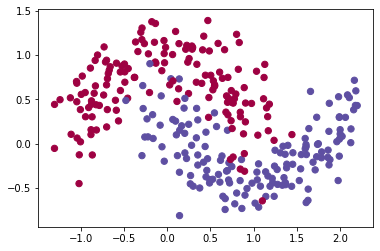

In [8]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)

## 定义模型

In [9]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,
          mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,
          epsilon=1e-8,num_epochs=10000,print_cost=True,is_plot=True):

    """
    可以运行在不同优化器模式下的3层神经网络模型。

    参数：
        X - 输入数据，维度为（2，输入的数据集里面样本数量）
        Y - 与X对应的标签
        layers_dims - 包含层数和节点数量的列表
        optimizer - 字符串类型的参数，用于选择优化类型，【 "gd" | "momentum" | "adam" 】
        learning_rate - 学习率
        mini_batch_size - 每个小批量数据集的大小
        beta - 用于动量优化的一个超参数
        beta1 - 用于计算梯度后的指数衰减的估计的超参数
        beta1 - 用于计算平方梯度后的指数衰减的估计的超参数
        epsilon - 用于在Adam中避免除零操作的超参数，一般不更改
        num_epochs - 整个训练集的遍历次数，（视频2.9学习率衰减，1分55秒处，视频中称作“代”）,相当于之前的num_iteration
        print_cost - 是否打印误差值，每遍历1000次数据集打印一次，但是每100次记录一个误差值，又称每1000代打印一次
        is_plot - 是否绘制出曲线图

    返回：
        parameters - 包含了学习后的参数

    """
    L = len(layers_dims)
    costs = []
    t = 0 #每学习完一个minibatch就增加1
    seed = 10 #随机种子

    #初始化参数
    parameters = opt_utils.initialize_parameters(layers_dims)

    #选择优化器
    if optimizer == "gd":
        pass #不使用任何优化器，直接使用梯度下降法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters) #使用动量
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)#使用Adam优化
    else:
        print("optimizer参数错误，程序退出。")
        exit(1)

    #开始学习
    for i in range(num_epochs):
        #定义随机 minibatches,我们在每次遍历数据集之后增加种子以重新排列数据集，使每次数据的顺序都不同
        seed = seed + 1
        minibatches = random_mini_batches(X,Y,mini_batch_size,seed)

        for minibatch in minibatches:
            #选择一个minibatch
            (minibatch_X,minibatch_Y) = minibatch

            #前向传播
            A3 , cache = opt_utils.forward_propagation(minibatch_X,parameters)

            #计算误差
            cost = opt_utils.compute_cost(A3 , minibatch_Y)

            #反向传播
            grads = opt_utils.backward_propagation(minibatch_X,minibatch_Y,cache)

            #更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentun(parameters,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters , v , s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        #记录误差值
        if i % 100 == 0:
            costs.append(cost)
            #是否打印误差值
            if print_cost and i % 1000 == 0:
                print("第" + str(i) + "次遍历整个数据集，当前误差值：" + str(cost))
    #是否绘制曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

    return parameters

## 使用普通的梯度下降

第0次遍历整个数据集，当前误差值：0.690735512291113
第1000次遍历整个数据集，当前误差值：0.6852725328458241
第2000次遍历整个数据集，当前误差值：0.6470722240719003
第3000次遍历整个数据集，当前误差值：0.6195245549970403
第4000次遍历整个数据集，当前误差值：0.5765844355950944
第5000次遍历整个数据集，当前误差值：0.6072426395968575
第6000次遍历整个数据集，当前误差值：0.5294033317684576
第7000次遍历整个数据集，当前误差值：0.46076823985930115
第8000次遍历整个数据集，当前误差值：0.465586082399045
第9000次遍历整个数据集，当前误差值：0.46451797221676844


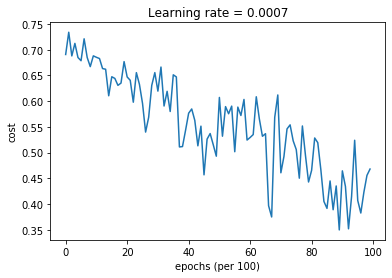

Accuracy: 0.7966666666666666


In [10]:
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd",is_plot=True)
preditions = opt_utils.predict(train_X,train_Y,parameters)

## 使用Momentum梯度下降

第0次遍历整个数据集，当前误差值：0.6907412988351506
第1000次遍历整个数据集，当前误差值：0.6853405261267578
第2000次遍历整个数据集，当前误差值：0.6471448370095255
第3000次遍历整个数据集，当前误差值：0.6195943032076022
第4000次遍历整个数据集，当前误差值：0.5766650344073023
第5000次遍历整个数据集，当前误差值：0.607323821900647
第6000次遍历整个数据集，当前误差值：0.5294761758786997
第7000次遍历整个数据集，当前误差值：0.46093619004872366
第8000次遍历整个数据集，当前误差值：0.465780093701272
第9000次遍历整个数据集，当前误差值：0.4647395967922748


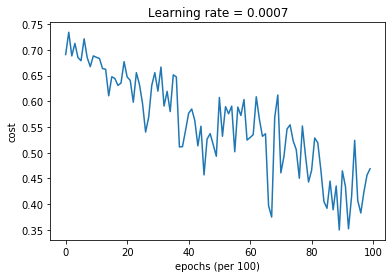

Accuracy: 0.7966666666666666


In [11]:
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, beta=0.9,optimizer="momentum",is_plot=True)
preditions = opt_utils.predict(train_X,train_Y,parameters)

## 使用Adam梯度下降

第0次遍历整个数据集，当前误差值：0.6905522446113365
第1000次遍历整个数据集，当前误差值：0.18550136438550574
第2000次遍历整个数据集，当前误差值：0.1508304657525321
第3000次遍历整个数据集，当前误差值：0.0744543857099718
第4000次遍历整个数据集，当前误差值：0.12595915651337158
第5000次遍历整个数据集，当前误差值：0.10434443534245481
第6000次遍历整个数据集，当前误差值：0.10067637504120651
第7000次遍历整个数据集，当前误差值：0.031652030135115604
第8000次遍历整个数据集，当前误差值：0.11197273131244204
第9000次遍历整个数据集，当前误差值：0.1979400715246548


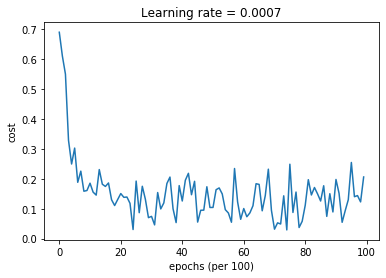

Accuracy: 0.94


In [12]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer="adam",is_plot=True)
preditions = opt_utils.predict(train_X,train_Y,parameters)

# 总结
<img src="20190615211730.png" style="width:550px;height:150px;">
   具有动量的梯度下降通常可以有很好的效果，但由于小的学习速率和简单的数据集所以它的影响几乎是轻微的。另一方面，Adam明显优于小批量梯度下降和具有动量的梯度下降，如果在这个简单的模型上运行更多时间的数据集，这三种方法都会产生非常好的结果，然而，我们已经看到Adam收敛得更快。